In [1]:

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import math
import numpy as np
import torch as t
import torch.utils.data as tdata
import matplotlib.pyplot as plt
from einops import rearrange
from dots.training import *
from dots.trainhooks import *
from dots.models import MLP
from dots.dots import *
from dots.utils import *
from dots.plotting import *

In [20]:
def sawtooth_mlp(layers):
    hidden = [2 ** layers] + flatten([[1, 2] for _ in range(layers - 1)])
    mlp = MLP(1, 1, hidden=hidden)
    return mlp

In [43]:
sawtooth_mlp(4).layers

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=1, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1, out_features=2, bias=True)
  (5): ReLU()
  (6): Linear(in_features=2, out_features=1, bias=True)
  (7): ReLU()
  (8): Linear(in_features=1, out_features=2, bias=True)
  (9): ReLU()
  (10): Linear(in_features=2, out_features=1, bias=True)
  (11): ReLU()
  (12): Linear(in_features=1, out_features=2, bias=True)
  (13): ReLU()
  (14): Linear(in_features=2, out_features=1, bias=True)
)

In [31]:
sawtooth_mlp(4).layers[0].weight

Parameter containing:
tensor([[-0.4045],
        [ 0.1455],
        [ 0.2016],
        [ 0.6437],
        [-0.5971],
        [-0.1465],
        [ 0.1506],
        [ 0.2316],
        [-0.3579],
        [-0.7499],
        [-0.1235],
        [-0.1943],
        [-0.6222],
        [ 0.8641],
        [ 0.1295],
        [-0.4704]], requires_grad=True)

In [32]:
sawtooth_mlp(4).layers[0].bias

Parameter containing:
tensor([ 0.6999,  0.4873,  0.5418, -0.4534,  0.0632, -0.9507,  0.3333, -0.8462,
         0.0151, -0.5384, -0.1848, -0.5391,  0.5639,  0.5558, -0.0861, -0.7959],
       requires_grad=True)

In [112]:
def deep_sawtooth(layers):
    model = sawtooth_mlp(layers)
    for i in range(0, len(model.layers), 2):
        model.layers[i].weight.data.fill_(0)
        model.layers[i].bias.data.fill_(0)
    ## implement identity:
    #model.layers[0].weight.data[0] = 1.0
    #model.layers[2].weight.data[0] = 1.0
    #for i in range(4, len(model.layers), 2):
    #    model.layers[i].weight.data[0] = 1.0
    for i in range(0, len(model.layers), 4):
        j = i + 2
        #print(f"i: {i}, j: {j}")
        #print(f"i weight size: {model.layers[i].weight.data.size()}")
        #print(f"j weight size: {model.layers[j].weight.data.size()}")
        #print(f"i bias size: {model.layers[i].bias.data.size()}")
        #print(f"j bias size: {model.layers[j].bias.data.size()}")
        model.layers[i].weight.data[0][0] = 1.0
        model.layers[j].weight.data[0][0] = 2.0
        model.layers[i].weight.data[1][0] = 1.0
        model.layers[i].bias.data[1] = -0.5
        model.layers[j].weight.data[0][1] = -4.0
    return model

def shallow_sawtooth(layers):
    model = sawtooth_mlp(layers)
    for i in range(0, len(model.layers), 2):
        model.layers[i].weight.data.fill_(0)
        model.layers[i].bias.data.fill_(0)
    for i in range(4, len(model.layers), 2):
        model.layers[i].weight.data[0] = 1.0
    for i in range(0, 2**layers):
        slope = 2 if i % 2 == 0 else -2
        if i == 0:
            slope = 1
        model.layers[2].weight.data[0][i] = slope * (2 ** layers)
        model.layers[0].weight.data[i][0] = 1.0
        model.layers[0].bias.data[i] = -i / (2 ** layers)
    return model

/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/dots/dots/notebooks/../dots/plotting.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


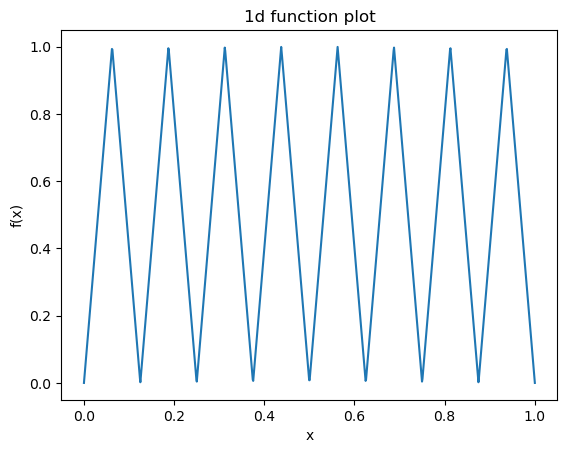

In [118]:
plot_1d_fn(deep_sawtooth(4), 0, 1, 1000)

/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/dots/dots/notebooks/../dots/plotting.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


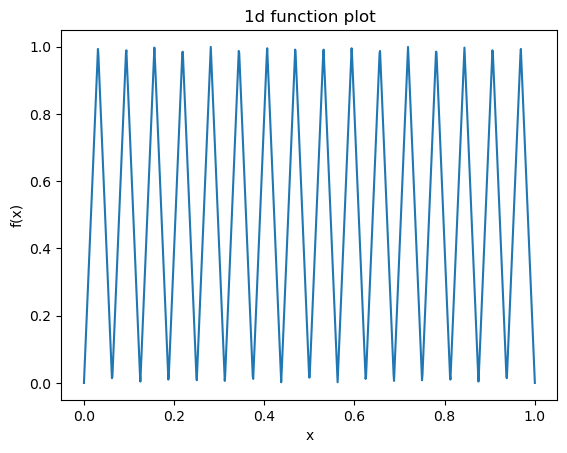

In [120]:
plot_1d_fn(shallow_sawtooth(5), 0, 1, 1000)

In [126]:
jac = matrix_jacobian(deep_sawtooth(4), range_batch(0, 1, 1000))

In [130]:
t.linalg.svd(jac)

torch.return_types.linalg_svd(
U=tensor([[-4.2522e-02,  2.2066e-02,  1.6370e-02,  ..., -9.7231e-04,
         -2.9515e-03,  2.4902e-03],
        [ 1.5297e-02, -4.5135e-02,  2.6632e-02,  ..., -5.0413e-04,
         -5.4302e-04,  1.5953e-03],
        [-1.5697e-02,  4.6334e-02, -2.4935e-02,  ...,  8.2781e-06,
         -3.4649e-05, -3.9620e-05],
        ...,
        [ 7.9838e-03,  5.5390e-03,  6.0699e-02,  ...,  9.9020e-01,
          1.8355e-04,  3.5654e-03],
        [-8.2622e-03, -7.2741e-03, -6.1937e-02,  ..., -1.2543e-03,
          9.7944e-01, -1.2897e-02],
        [-8.2160e-03, -7.0074e-03, -6.1487e-02,  ...,  2.8028e-03,
         -1.4718e-02,  9.7937e-01]]),
S=tensor([1.0707e+03, 5.3031e+02, 3.5209e+02, 2.3230e+02, 1.1280e+02, 8.7418e+01,
        4.6359e+01, 2.3162e+01, 1.4191e+01, 9.7918e+00, 9.9304e-05, 7.9739e-05,
        5.9965e-05, 5.9965e-05, 5.9965e-05, 5.9965e-05, 5.9965e-05, 5.9965e-05,
        5.9965e-05, 5.9965e-05, 5.9965e-05, 5.9965e-05, 5.9965e-05, 5.9965e-05,
        5.99

Assuming trainplot_1d got a model, not a trainstate


/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-pack

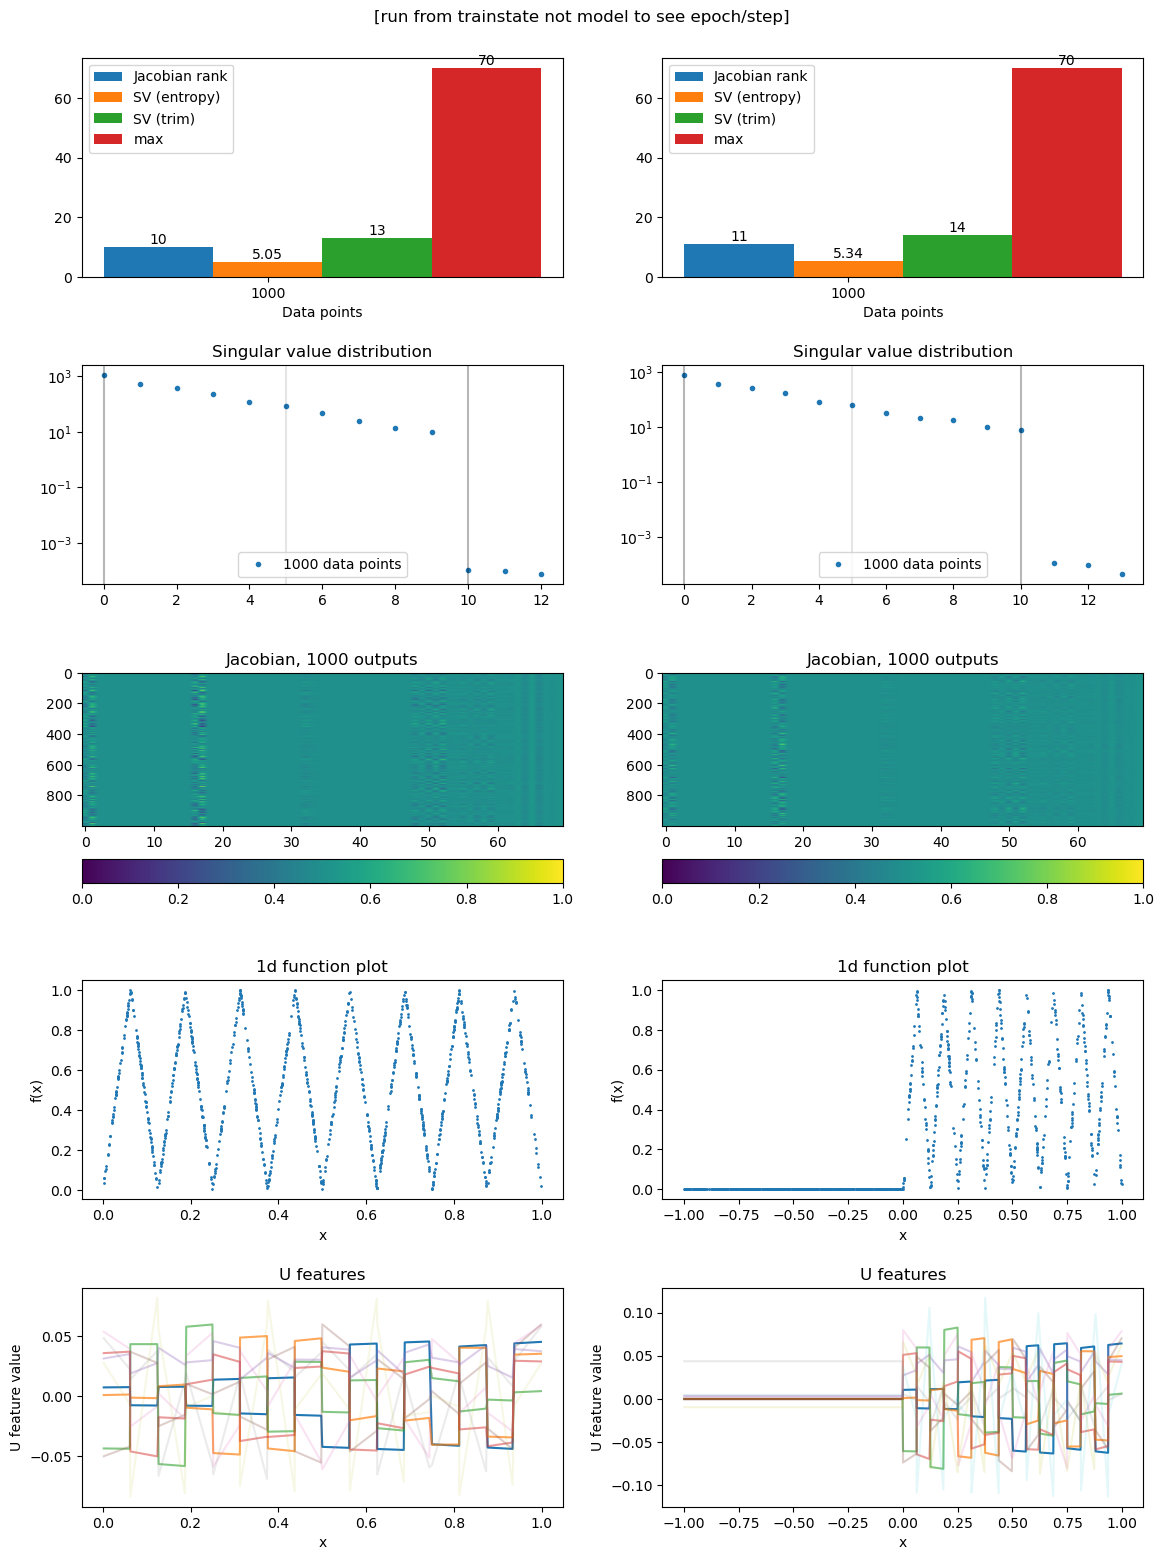

In [132]:
fig = trainplot_1d(deep_sawtooth(4), range_batch(0, 1, 1000))

Assuming trainplot_1d got a model, not a trainstate


/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-pack

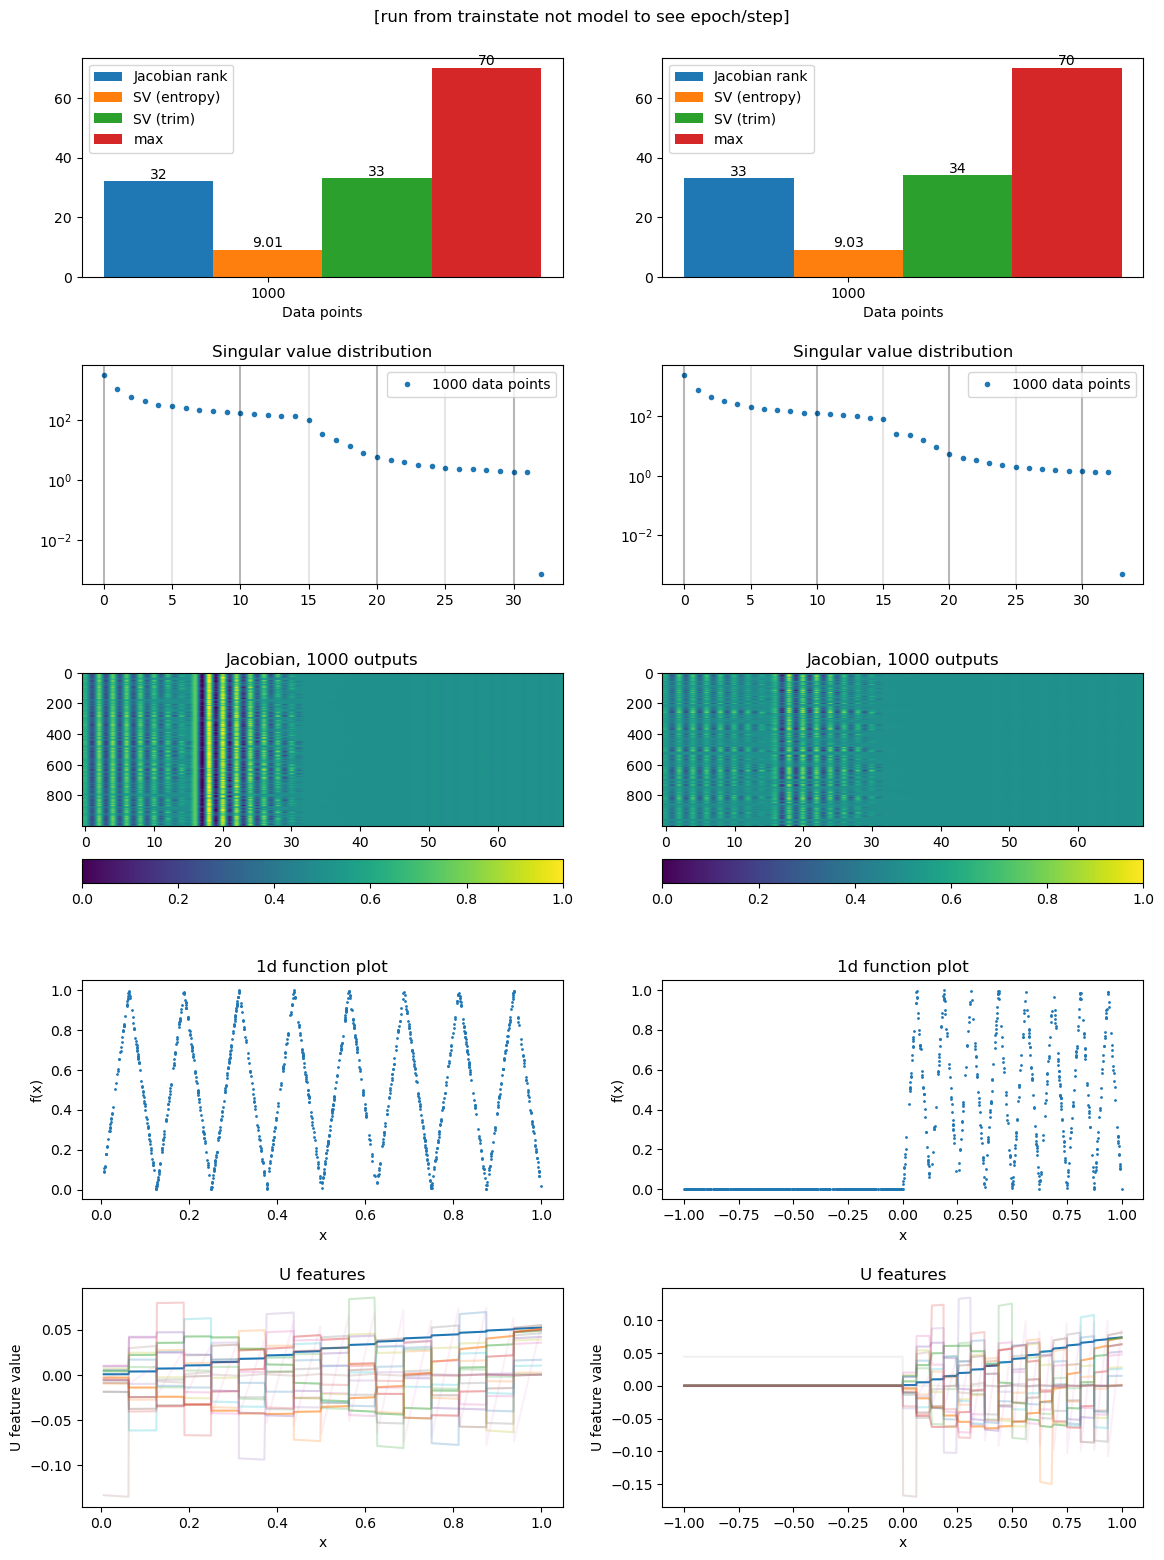

In [133]:
fig = trainplot_1d(shallow_sawtooth(4), range_batch(0, 1, 1000))

/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/dots/dots/notebooks/../dots/plotting.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/dots/dots/notebooks/../dots/plotting.py:121: UserWarning: Matplotlib is currently using m

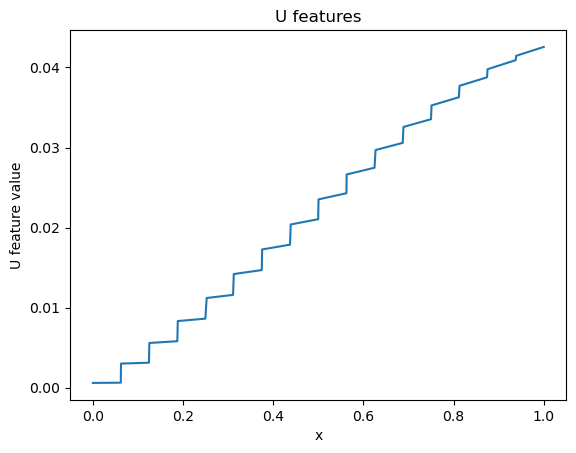

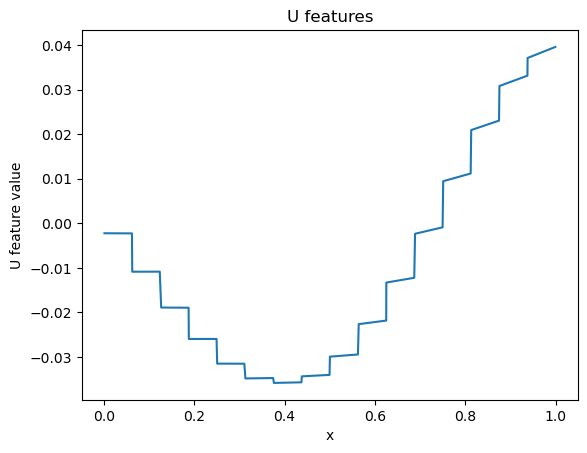

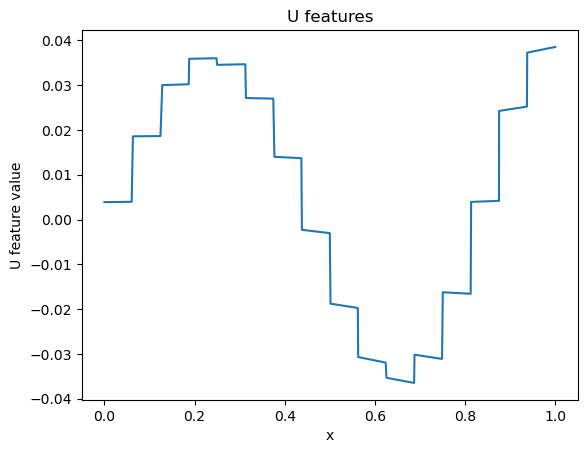

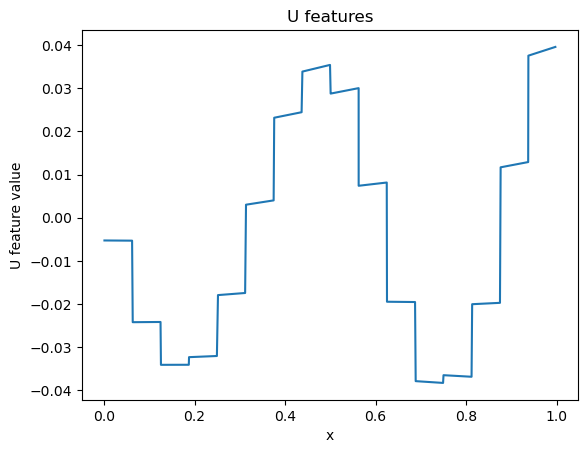

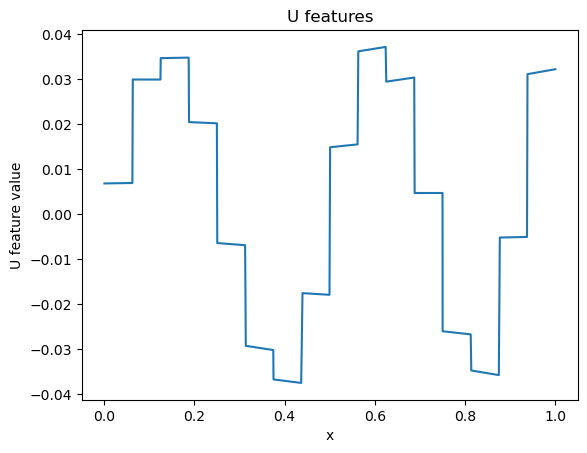

In [137]:
for i in range(0, 5):
    fig = plot_1d_u_feats(shallow_sawtooth(4), range_batch(0, 1, 1500), which_feat=i)

/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/dots/dots/notebooks/../dots/plotting.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/dots/dots/notebooks/../dots/plotting.py:121: UserWarning: Matplotlib is currently using m

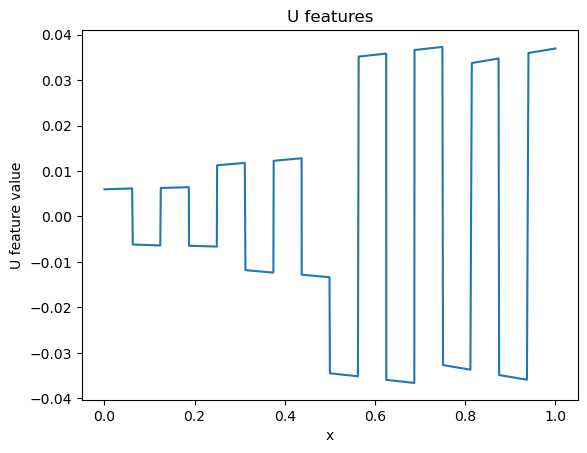

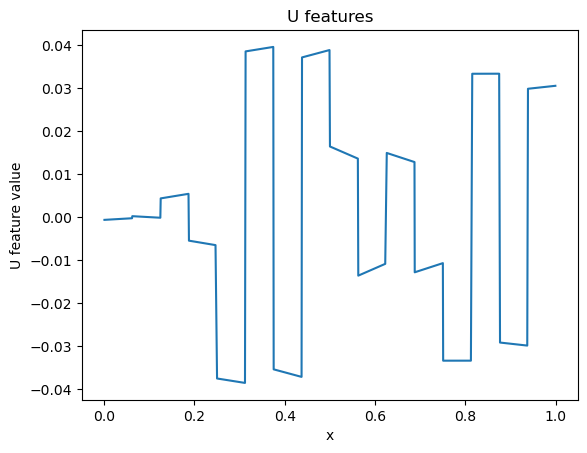

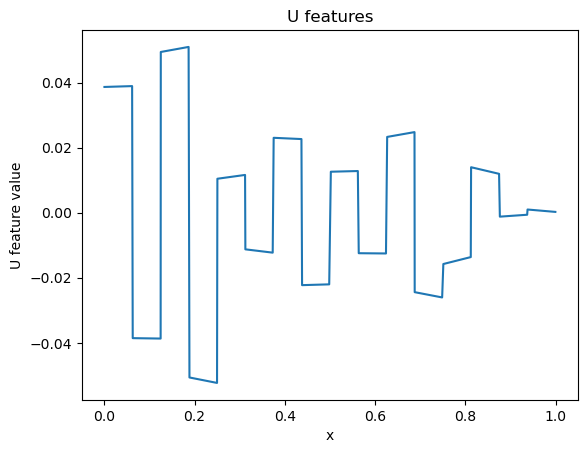

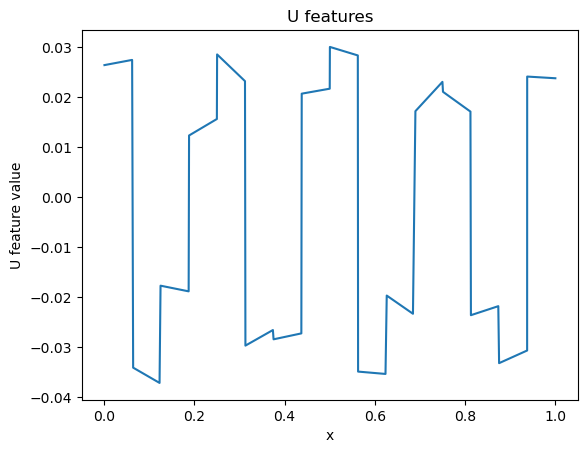

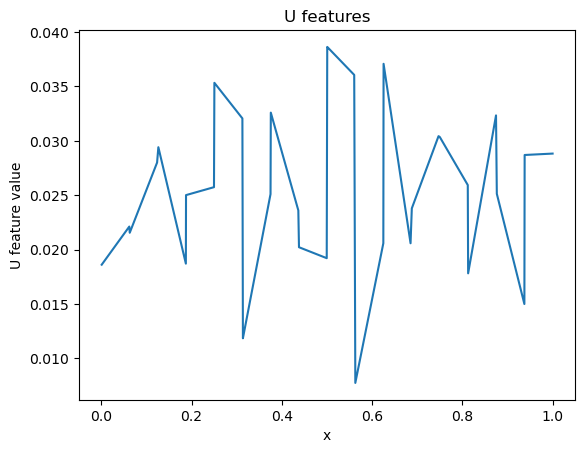

In [136]:
for i in range(0, 5):
    fig = plot_1d_u_feats(deep_sawtooth(4), range_batch(0, 1, 1500), which_feat=i)